In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import networkx as nx

In [2]:
def organise_labels(x):
  task=[]
  times=[]
  for element in x:
    if ':' in element:
      task.append(element.split(':')[0])
      times.append(float(element.split(':')[1].replace('seconds',' ').replace('sec','').strip()))
    else:
      task.append('unknown')
      times.append(float(element.replace('seconds','').replace('secs','').strip()))

  task_list=list(set(task))
  tasks_dict=dict()
  for i in range(len(times)):
    if task[i] in tasks_dict.keys():
      tasks_dict[task[i]].append(times[i])
    else:
      tasks_dict[task[i]]=[times[i]]
  formatted_str=[]

  for taskname in tasks_dict.keys():
    formatted_str.append(taskname +':'+ str(round(np.mean(tasks_dict[taskname]),0)) + 'seconds')
  return ('\n'.join(formatted_str))

In [3]:
def graph_building(Data_IR,path_name):
  Data_IR.loc[:,"old_task_id"]=Data_IR.inst_book_section_exercise_id.shift(1)
  Data_IR.loc[0,'old_task_id']=int(0)
  Data_IR=Data_IR.loc[(Data_IR.inst_book_section_exercise_id!=Data_IR.old_task_id),\
                         ['inst_book_section_exercise_id','old_task_id','Action Time']]

  MG = nx.MultiDiGraph() 
  G=nx.from_pandas_edgelist(Data_IR, source='old_task_id', target='inst_book_section_exercise_id',create_using=nx.DiGraph())
  event_list=[]
  for edge in G.edges:
    event_list.append(edge[0])
    event_list.append(edge[1])
  EV=sorted(list(set(event_list)))
  n=len(EV)

  MG.add_nodes_from(EV)
  p=np.ceil(n**0.5)
  for edge in G.edges:
    L=[]
    DF=Data_IR.loc[(Data_IR.old_task_id==edge[0])&(Data_IR.inst_book_section_exercise_id==edge[1]),["Action Time"]]
    if DF.shape[0]==1:
      L.append((edge[0],edge[1],dict(act_time=str(DF['Action Time'].values[0]))))
    else:
      L.append((edge[0],edge[1],dict(act_time=organise_labels(DF['Action Time'].values))))
    MG.add_edges_from(L)
  
  labelPosDict=dict()
  nodePosDict =dict()
  for i in range(n):
    labelPosDict[EV[i]]=[p*(i//p),i%p]
    nodePosDict[EV[i]]=[p*(i//p),i%p]
  
  plt.figure(figsize=(22, 10), dpi=600)
  auto_pos=nx.spring_layout(MG)
  labels=dict([((u,v),d['act_time']) for u,v,d in MG.edges(data=True)])
  nx.draw_networkx_edge_labels(MG,pos=labelPosDict, edge_labels=labels)
  nx.draw(MG,with_labels=True, pos=nodePosDict,node_color="orange",
      node_size=2500, alpha=0.3, font_weight="bold", font_size=12, arrows=True,
      connectionstyle='arc3, rad=0.2',edge_color='green', width=4)
 
  plt.axis('on')
  plt.title(path_name.split('/')[-1].replace('.csv',''))
  plt.savefig('activity_chart.png',dpi=300)

In [4]:
path_name="/Users/abilash/Downloads/student56.csv"

In [5]:
Data_IR2=pd.read_csv(path_name)

In [6]:
Data_clean=Data_IR2[['Action Time','inst_book_section_exercise_id']].dropna(inplace=False)

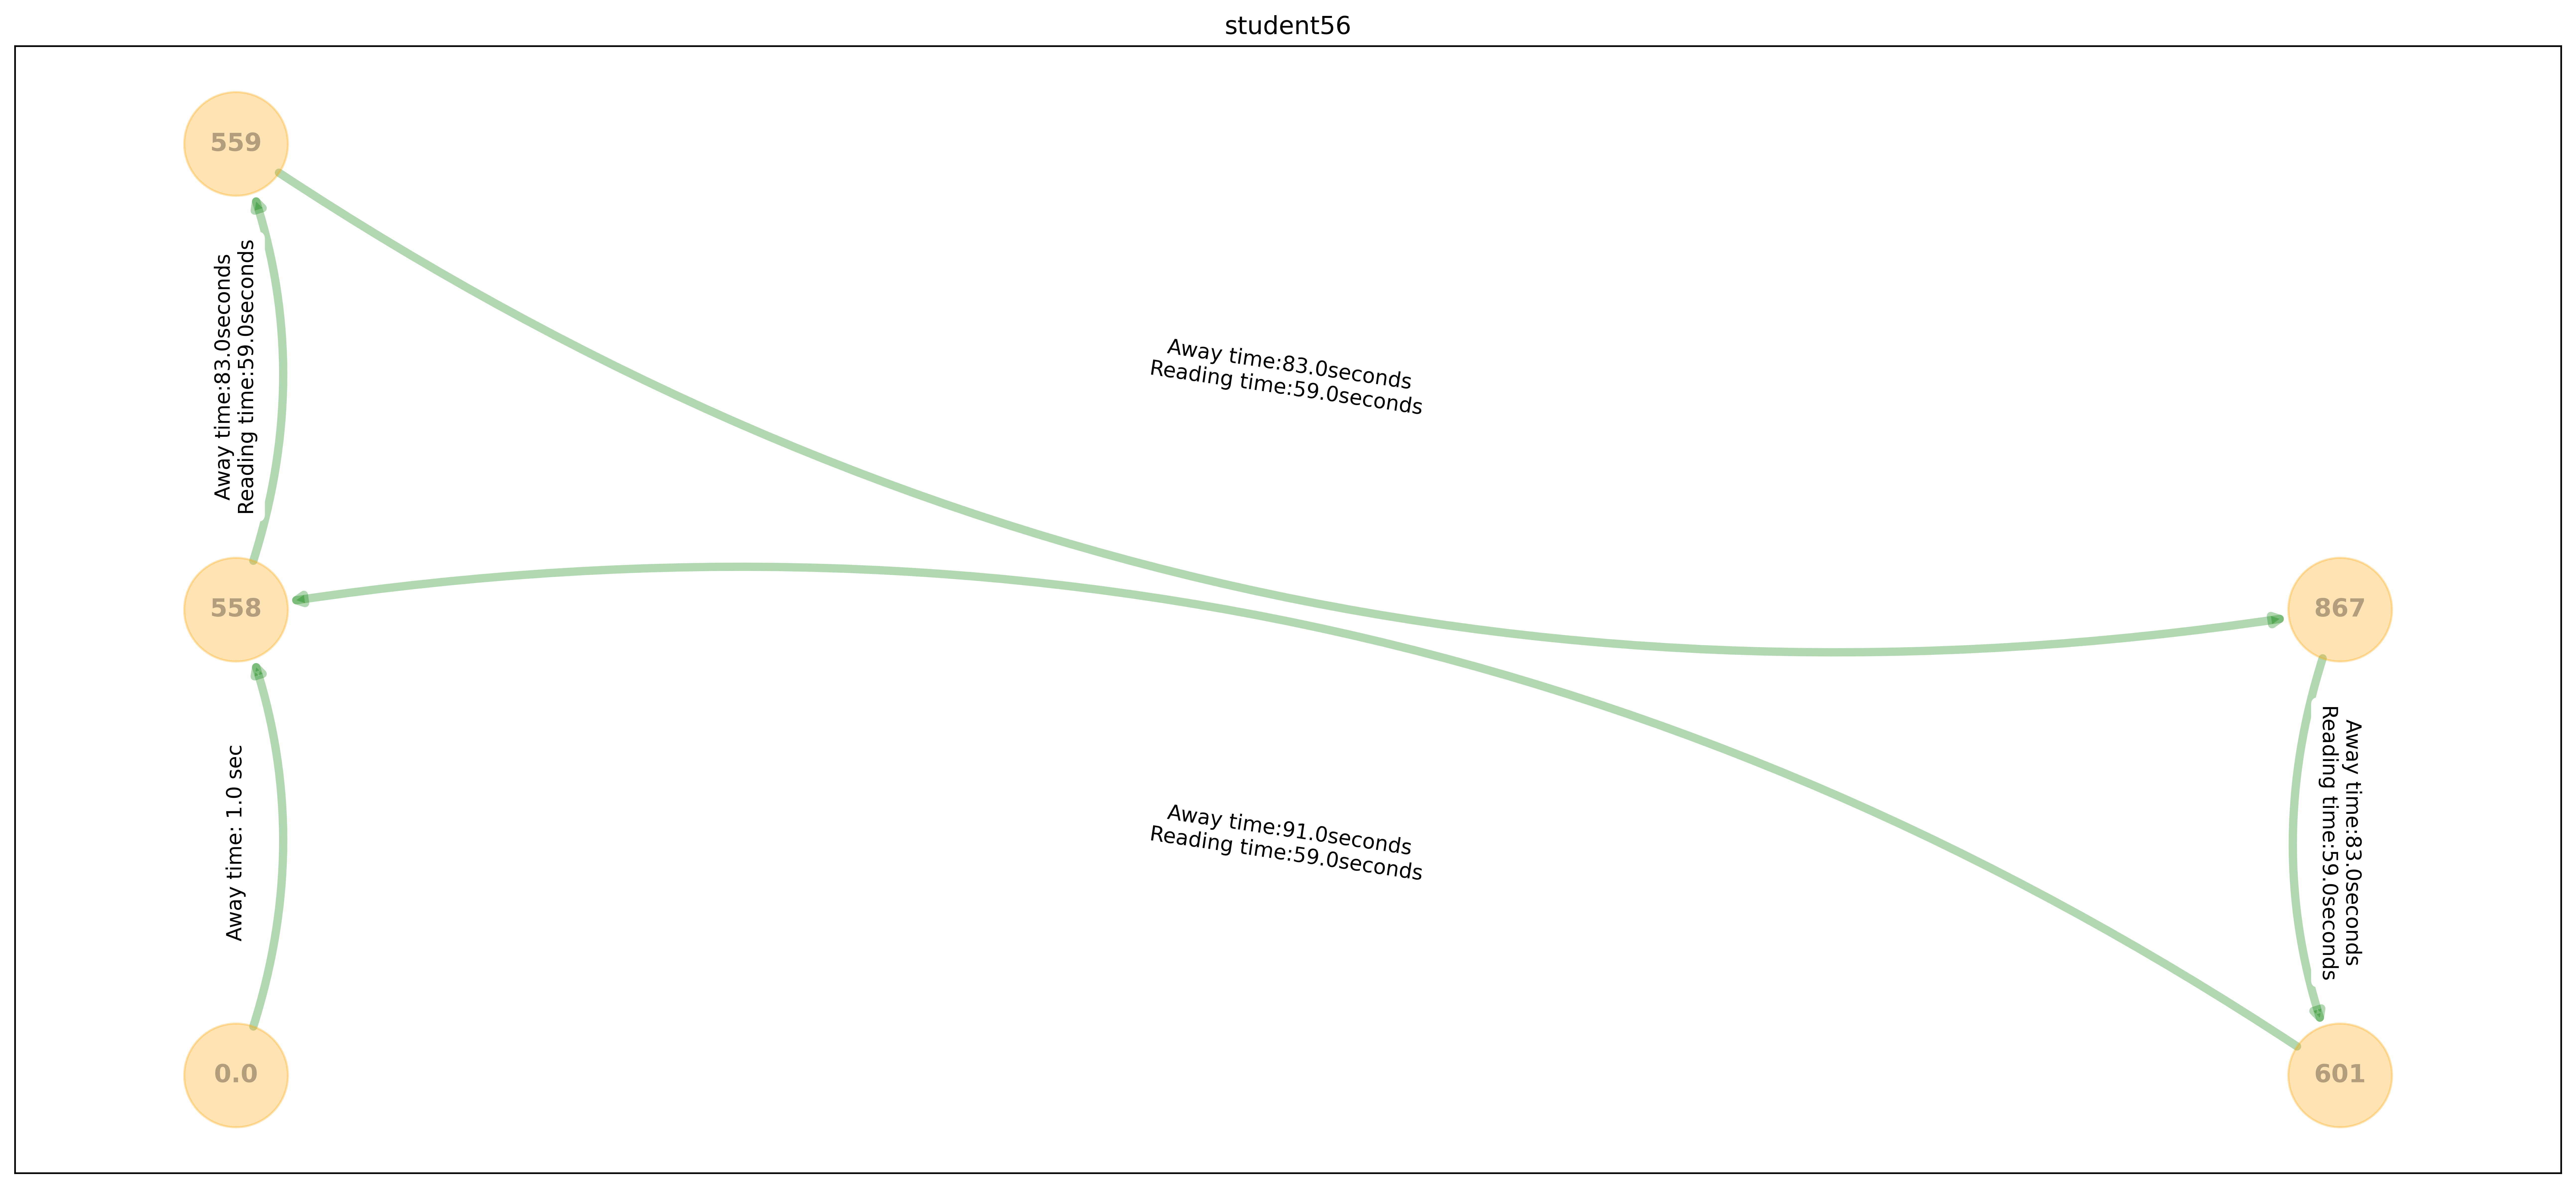

In [7]:
graph_building(Data_clean,path_name)